# Tutorial - Quantum Reservoir Computing

### by Philipp Pfeffer and Jörg Schumacher (TU Ilmenau, Germany)

This tutorial demonstrates some basic working principles of quantum reservoir computing models for a simple nonlinear time series reconstruction task. The example time series follows from a NARMA model.  

## 1. Nonlinear time series - NARMA-2 model

We use the NARMA-2 model which is an input-output system that generates a complex time series. It is given by the equations ($u_t$ is the input)

\begin{align}
u_t \ &= \ 0.1 \left(\sin(2\pi \alpha t) \sin(2\pi \beta t) \sin(2\pi \gamma t) +1 \right) \\
y_{t+1} \ &= \ 0.4y_t+ 0.4y_t y_{t-1} + 0.6 u_t^3 + 0.1
\end{align}

with coefficients $\alpha = 2.11/T$, $\beta = 3.73/T$, $\gamma = 4.11/T$, discrete time $t\in \mathbb{N}$ and $T=100$.

The following code block simulates the NARMA-2 model for 500 time steps and plots the results. The initial values are $y_0=y_1=0.195$. The name NARMA model stands for **N**onlinear **A**uto-**R**egressive **M**oving-**A**verage model. It is named NARMA-2 because $y_{t+1}$ depends on $y_t$ and $y_{t-1}$.

100%|██████████| 499/499 [00:00<00:00, 409340.45it/s]


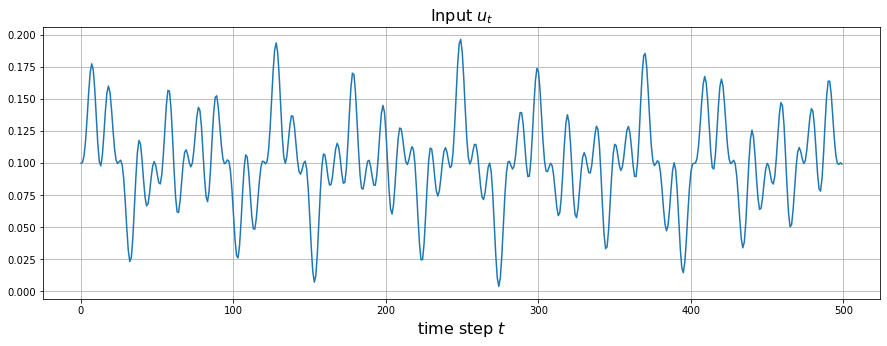

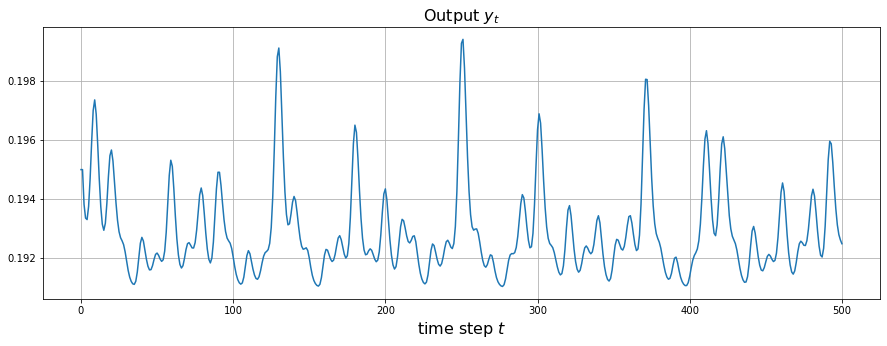

In [35]:
import numpy as np                 # Standard math package
import matplotlib.pyplot as plt    # Standard plot package
from tqdm import trange            # adds loading bars to for loops

#---construct u - input
k_ = np.arange(500)
param = np.array([2.11,3.73,4.11])/100
u = 0.1*(np.sin(2*np.pi*param[0]*k_)*np.sin(2*np.pi*param[1]*k_)*np.sin(2*np.pi*param[2]*k_)+1 )

#---construct y - output
y = np.zeros(501)
y[:2]=0.195
for k in trange(1,500):
    y[k+1] = 0.4*y[k]*(1+y[k-1])+0.6*(u[k]**3)+0.1

#---plot input and output with some common features
plt.figure(figsize=(15,5))
plt.plot(u) , plt.grid() , plt.title('Input $u_t$',fontsize=16)
plt.xlabel('time step $t$',fontsize=16)

plt.figure(figsize=(15,5))
plt.plot(y) , plt.grid() , plt.title('Output $y_t$',fontsize=16)
plt.xlabel('time step $t$',fontsize=16)
plt.show()

## 2. Quantum reservoir computing environment

In order to implement the quantum reservoir computing algorithm, the following steps are necessary:
1. Implement the update equation
2. Iterate over timesteps
3. Generate output weights and compare results

### 2.1 Quantum Circuits
To get started, we will set up a function that returns a quantum circuit which
- has $n$ qubits
- implements $R_Y$ gates on all qubits
- encodes the input $u_t$ in the first $R_Y$ gate
- encodes random parameters $\beta$ as arguments of further $R_Y$ gates

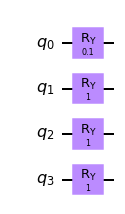

In [36]:
from qiskit import QuantumCircuit 

def qrc_circ(n, u , p):

#---fill from here
    qc = QuantumCircuit(n)
    qc.ry(u,0)
    for k in range(1,n):
        qc.ry(p[k-1],k)
#---end fill
    return qc

circ = qrc_circ(4,u[0],np.ones(4))
circ.draw('mpl')

### 2.2 Statevector versus QASM backends
In order to evaluate the circuit, a backend is required  to run the circuit and return either the final statevector of the quantum circuit or measurements sampled from the circuit. 

The **statevector backend** returns the $2^n$-dimensional complex vector of an $n$-qubit quantum circuit. Therefore:
- a $2^n$-dimensional vector is returned that contains the measurement probabilites
- the only input is the circuit which has to be evaluated

In [37]:
from qiskit import Aer, execute

def state_vec(circuit):

#---Define backend b_end
    b_end = Aer.get_backend('statevector_simulator')

#---Obtain statevector sv
    sv = execute(circuit,b_end).result().get_statevector()
    
    return np.abs(sv)**2

#---Check the result
print('Check if probabilities sum to 1. Result: '+format(np.round(np.sum(state_vec(circ)),14)))

Check if probabilities sum to 1. Result: 1.0


The **QASM backend** is a simulator which works closer to real quantum computers, as it simulates the measurement process which is inevitable for real quantum computers. QASM stands for **Q**uantum **As**se**m**bly language. Therefore:

- a $2^n$ sized vector is returned filled with the probabilites of measuring the possible outcomes of the quantum circuit
- the inputs are the circuit (without measurement) and the amount of shots

**Technical details:**
- In order to not corrupt the input quantum circuit, the initial part of the function makes a copy to **this_qc**
- Measurements on all qubits are implemented by **this_qc.measure_all()**  
- The sampling results can be extracted by **execute(this_qc).result().get_counts()** which returns a dictionary
- The dictionary needs to be transformed into a np.array for further processing:
    - create an empty array with np.zeros(2**n)
    - search in the keys of the dictionary to fill the elements. 
      For instance, create a for-loop with $k\in \{0,1,...,2^n-1\}$ and check whether the key = format(k, '0' + str(n)+'b') is in the dictionary 
    - If a key 'key' is in a dictionary 'd' can be checked with 'if key in d:
    - The element found in the dictionary states how often this output is measured. In order to obtain the probability, one needs to divide by the amount of all samples made

In [38]:
def shots_vec(circuit, samples):
    this_qc = circuit.copy()
    
    n = this_qc.num_qubits # helps to browse dictionary
    
    this_qc.measure_all()

#---Define backend b_end
    b_end = Aer.get_backend('qasm_simulator') 

#---Shots means number of repeated identically prepared runs
    job = execute(this_qc, b_end, shots=samples).result()
    res = job.get_counts()

#---Initialize an array for the result
    vec = np.zeros(2**n)
    
    for kkk in range(0,2**n):
            key = format(kkk, '0' + str(n)+'b')
            if key in res:
                 vec[kkk] = res[key]/samples 
    
    return vec

#---Check the result for 2**10 shots
print('Check if probabilities sum to 1. Result: '+format(np.round(np.sum(shots_vec(circ,2**10)),14)))

Check if probabilities sum to 1. Result: 1.0


Compare the results from statevector and QASM backends

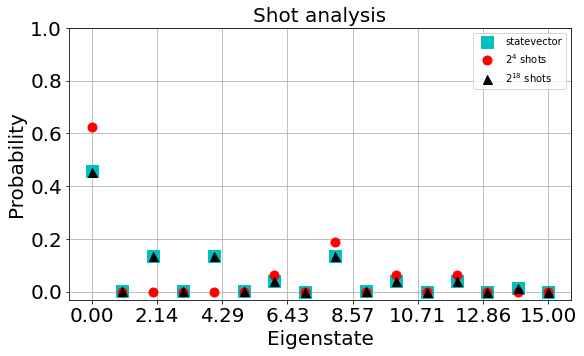

In [39]:
#---Define plot data - Statevector run
res_statevec = state_vec(circ)        

#---Define plot data - QASM runs
res_04shots  = shots_vec(circ,2**4)   
res_18shots  = shots_vec(circ,2**18)  

#---Plot results
plt.figure(figsize=(9,5))
plt.plot(res_statevec,'cs',label='statevector',markersize=12)
plt.plot(res_04shots,'ro',label='$2^4$ shots',markersize=9)
plt.plot(res_18shots,'k^',label='$2^{18}$ shots',markersize=9)
plt.title('Shot analysis', fontsize=20)
plt.xlabel('Eigenstate', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.xticks(np.linspace(0, 15, 8, endpoint =True), fontsize=20)
plt.yticks(np.linspace(0, 1, 6, endpoint =True), fontsize=20)
plt.legend()
plt.grid()
plt.show()

### 2.3 Training and test data generation by quantum reservoir

For quantum reservoir computing, the update equation of the $2^n$-dimensional reservoir state vector ${\bf r}(t)$ is as follows

\begin{align}
{\bf r}_{t+1} = (1-\varepsilon)\,{\bf r}_t  + \varepsilon \sum\limits_{k=1}^{2^n} \vert \langle k \vert U(u_t,{\boldsymbol{\beta}})\vert 0 \rangle\vert^2 \,\vert k \rangle \,,
\end{align}

where $|k\rangle$ is the $k$-th standard basis vector of the quantum register. The vector $\boldsymbol{\beta}$ consists of random parameters.

We now create the **reservoir matrix** $R\in \mathbb{R}^{500\times2^n}$ from the input time series $u_t$ of the NARMA-2 model.

**Technical details:** 
- Use np.random.random($x$) which generates $x$ random values, while **random.seed(par_seed)** makes those numbers reproducible through par_seed. 
- create an empty matrix $R$= np.zeros((500,2**n))
- for the initial state: set $R$[0,0]=1
- implement the update equation above, using the qrc_circ function and the state_vec function

In [40]:
#---No. of qubits
n = 1 

#---Leaking rate
epsilon = 0.2

np.random.seed(n)
randoms = np.random.random(n)

#---Generate filled Reservoir Matrix
R = np.zeros((500,2**n))
R[0,0] = 1

for k in trange(1,500):   
    R[k,:] = (1-epsilon)*R[k-1,:] + epsilon * state_vec( qrc_circ(n, u[k] , randoms)  ) 

100%|██████████| 499/499 [00:01<00:00, 280.47it/s]


### 2.4 Output layer optimization

The final step of RC is to optimize the output layer. The reservoir matrix $R$ needs to be mapped to the output vector with the 200 **training output steps** ${\bf y}=(y_{100},...,y_{300})^T$ through the output weights ${\bf w}^T_\text{out}$ by

$$ {\bf y} \overset{!}{=} {\bf w}^T_\text{out} R \hspace{2em} \Rightarrow \hspace{2em} {\bf w}^T_\text{out} = {\bf y} R^{+}$$

The code below implements a comparison of data in training and validation. 

Training:
- For RC training, time stamps 100 to 300 are chosen.
- Start is at time step 100 in order to resemble (classical) reservoirs which need a **wash-out of the initial values**  
  
- after training the vector with the optimized weights, ${\bf w}^T_\text{out}$, is known


We now extend the code below to generate the output weights ${\bf w}^T_\text{out}$

**Technical details:**
- use the reservoir matrix $R$ and the output ${\bf y}$ for time steps $t\in [100,300]$ only. This can be done by y[t_a:t_b].
- The **pseudo-inverse** can be built with np.linalg.pinv(R)
- Matrix multiplication can be done with np.matmul(A,B)

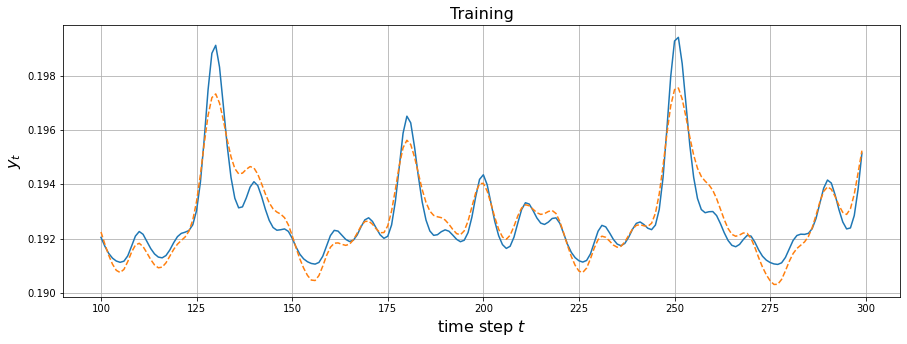

In [41]:
t_a,t_b = 100,300
W_out = np.matmul(np.linalg.pinv(R[t_a:t_b,:]),y[t_a:t_b]) # Fill code here

#---Output
plt.figure(figsize=(15,5))
plt.plot(np.arange(100,300),y[t_a:t_b])
plt.plot(np.arange(100,300),np.matmul(R[t_a:t_b,:],W_out),'--')
plt.grid()
plt.xlabel('time step $t$',fontsize=16) 
plt.ylabel('$y_t$',fontsize=16)
plt.title('Training',fontsize=16)
plt.show()

### 2.5 Validation

In the validation, here done after time step 300, one checks how good the reservoir reconstructs the output $y_t$ for the optimized weights ${\bf w}^T_\text{out}$ on **unseen data**, the reconstruction can be generated and compared to the ground truth (GT) output $y^{\rm GT}_t$.

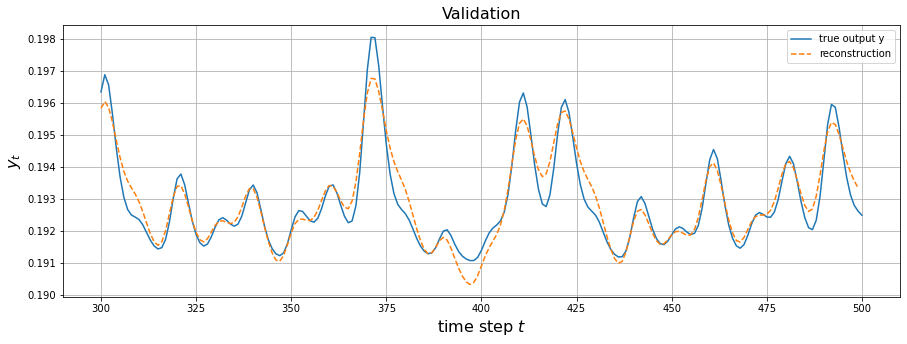

In [42]:
#---Output
plt.figure(figsize=(15,5))

plt.plot(np.arange(300,501),y[t_b:],label='true output y')
plt.plot(np.arange(300,500),np.matmul(R[t_b:,:],W_out),'--',label='reconstruction')
plt.grid() , plt.legend() , 
plt.xlabel('time step $t$',fontsize=16)
plt.ylabel('$y_t$',fontsize=16)
plt.title('Validation',fontsize=16)
plt.show()

## 3. More complex quantum circuits for the reservoir

As seen above, the NARMA-2 model is already reproduced quite well by just a single qubit circuit which just encodes the input. More qubits could help to improve the quality, but the extension needs to happen non-trivially. For instance, verify the following:

We now evaluate the quantum reservoir approach with more qubits. To this end, the input for the first $R_Y$ gate is $y_t$ again. Random inputs are assigned to the other $R_Y$ rotation gates. Compare the validation results for qubit numbers $n=1$, 3, and 7.

**Technical details:**
- use the code patches from above

100%|██████████| 499/499 [00:04<00:00, 122.64it/s]


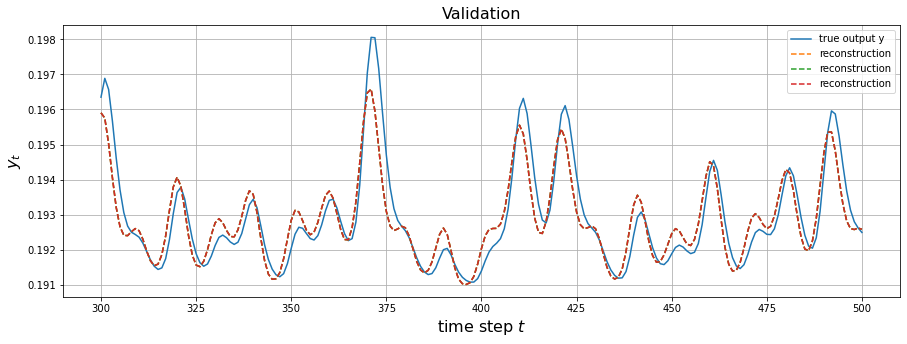

In [43]:
#---Training period
t_a,t_b = 100,300

plt.figure(figsize=(15,5))
plt.plot(np.arange(300,501),y[t_b:],label='true output y')


for n in [1,3,7]:
    np.random.seed(n)
    
    randoms = np.random.random(n)
    epsilon = 1

    R = np.zeros((500,2**n))
    R[0,0] = 1

    for kk in trange(1,500):

        R[kk,:] = (1-epsilon)*R[kk-1,:] + epsilon * state_vec( qrc_circ(n, u[kk] , randoms)  ) 
        
    W_out = np.matmul(np.linalg.pinv(R[t_a:t_b,:]),y[t_a:t_b])
    

#---If your reservoir matrix is not called R and output weights not W_out, edit the names below
    plt.plot(np.arange(300,501),np.matmul(R[t_b-1:,:],W_out),'--',label='reconstruction')
    
plt.grid() 
plt.xlabel('time step $t$', fontsize=16)
plt.ylabel('$y_t$', fontsize=16)
plt.legend() 
plt.title('Validation', fontsize=16)
plt.show()

We see that the larger reservoirs do not necessarily give better results. This may change if entanglement is added. The curves for $N=1, 3, 7$ collapse on each other.

We now change the circuit function such that the circuit has not one but three layers. 
- The **1st layer** stays as before. 
- The **2nd layer** should consist of CNOT-gates such that every qubit is entangled with at least one other qubit. 
- The **3rd layer** should again contain $R_Y$ gates with random parameters again. 

We repeat the previous evaluation for $n= 1,..,4$. 

**Technical details:**
- Copy the circuit function from above and adapt it appropriately in the first code block. 
- Draw the circuit to check the structure
- Copy the reservoir execution from before in the second code blcok and adapt it appropriately.
- The error is already printed by the code below with the norm of the difference between y and reconstruction


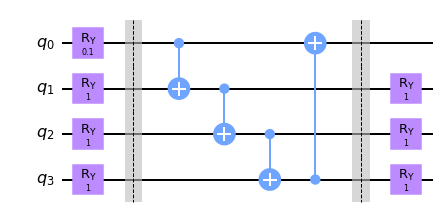

In [44]:
def qrc_circ_n(n, u , randoms):
    
#---n = number of qubits 
#   u = input time series
#   randoms = random values

    qc = QuantumCircuit(n)

#---Data input    
    qc.ry(u,0)

#---Fill with random values    
    for k in range(1,n):
        qc.ry(randoms[k-1],k)

    qc.barrier()
    
#---CNOT layer        
    for k in range(n-1):
        qc.cx(k,k+1)
    if(n>1):
        qc.cx(n-1,0)

    qc.barrier()
    
#---Fill with random values        
    for k in range(1,n): # starting from 1 improves performance
        qc.ry(randoms[n+k],k)
        
    return qc

#---Draw circuit
circ = qrc_circ_n(4,u[0],np.ones(2*4))
circ.draw('mpl')

n=1 Error = 0.0061071277585002135
n=2 Error = 0.0049870553595635705
n=3 Error = 0.004986954987397774
n=7 Error = 0.0049869504792256405


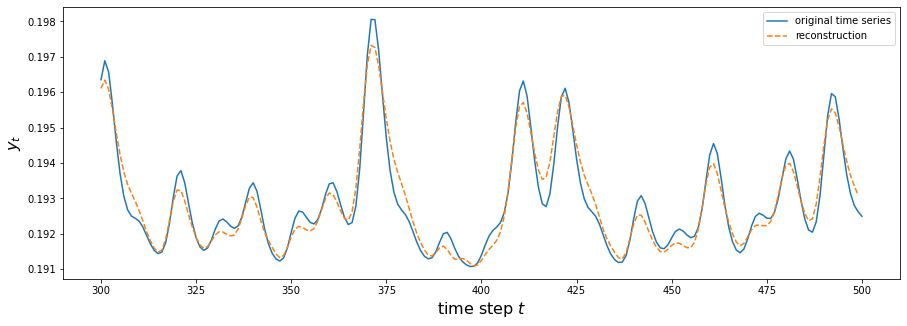

In [45]:
t_a,t_b = 100,300

for n in [1,2,3,7]:
    np.random.seed(n)
    
    randoms = np.random.random(2*n)
    epsilon = 0.2

    R = np.zeros((500,2**n))
    R[0,0] = 1

    for kk in range(1,500):

        R[kk,:] = (1-epsilon)*R[kk-1,:] + epsilon * state_vec( qrc_circ_n(n, u[kk] , randoms)  ) 
        
        

    W_out = np.matmul(np.linalg.pinv(R[t_a:t_b,:]),y[t_a:t_b])
    
    print('n='+format(n)+' Error = '+format(np.linalg.norm(y[t_b:-1]-np.matmul(R[t_b:,:],W_out))) )

#---Output    
plt.figure(figsize=(15,5))  

plt.plot(np.arange(300,501),y[t_b:], label='original time series')
plt.xlabel('time step $t$',fontsize=16)
plt.ylabel('$y_t$',fontsize=16)
plt.plot(np.arange(300,500),np.matmul(R[t_b:,:],W_out),'--',label='reconstruction')
plt.legend()

We conclude that there is no substantial improvement for qubit numbers $n>2$. Additional gates and qubits do not add dynamical properties if there is just one degree of freedom of input, it will just be transformed linearly. In principle, we have run so far a **quantum extreme learning machine**. 

This is changed if one adds further dynamics to the circuit, such as a bit of dynamical history by **delay embedding**. This introduces  **recurrency** and changes the reservoir from $U(u_t,\boldsymbol{\beta})$ to $U(u_t,r_t,\boldsymbol{\beta})$.

We now change the circuit function such that the first level of $R_Y$ gates receives dynamical inputs from the last reservoir time step. The remaining code is copied from above.

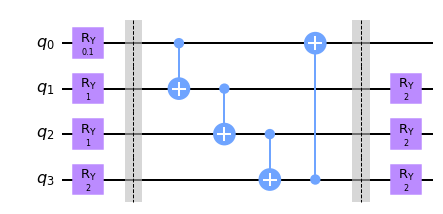

In [46]:
def qrc_circ_n(n, u ,r_in, p):
    
    qc = QuantumCircuit(n)

#---Data input    
    qc.ry(u,0)

#---Delay input    
    for k in range(1,int(np.min([3,n]))):
        qc.ry(r_in[k-1],k)

    for k in range(int(np.min([3,n])),n):
        qc.ry(p[k],k)

    qc.barrier() 

#---CNOT layer            
    for k in range(n-1):
        qc.cx(k,k+1)
    if(n>1):
        qc.cx(n-1,0)

    qc.barrier()

#---Fill with random values            
    for k in range(1,n):
        qc.ry(p[k],k)
        
    return qc

#---Draw circuit
circ = qrc_circ_n(4,u[0],np.ones(4),2*np.ones(4))
circ.draw('mpl')

We now check for improvement by increasing the circuit size from n=1 to n=6.

**Technical details:**
- Edit the circuit function above, if necessary, and execute it below
- Copy the code from the last execution task and adapt it for the new circuit structure

n=1 Error = 0.00616260075154589
n=2 Error = 0.006335334338289382
n=3 Error = 0.0036698498755550215
n=4 Error = 0.0032397435750282223
n=5 Error = 0.003668044076157891


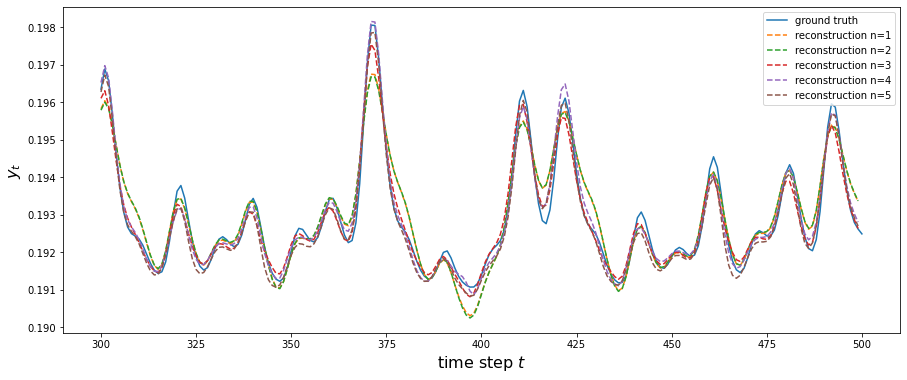

In [47]:
t_a,t_b = 100,300

plt.figure(figsize=(15,6))
plt.plot(np.arange(300,501),y[t_b:],label='ground truth')

for n in range(1,6): # qubit number handling

    np.random.seed(n)
    randoms = np.random.random(2*n)
    epsilon = 0.2

    R = np.zeros((500,2**n))
    R[0,0] = 1

    for kk in range(1,500):
        R[kk,:] = (1-epsilon)*R[kk-1,:] + epsilon * state_vec( qrc_circ_n(n, 3*u[kk] , R[kk-1,1:], randoms)  ) 
        
    W_out = np.matmul(np.linalg.pinv(R[t_a:t_b,:]),y[t_a:t_b])
    
    print('n='+format(n)+' Error = '+format(np.linalg.norm(y[t_b:-1]-np.matmul(R[t_b:,:],W_out))) )

    plt.plot(np.arange(300,500),np.matmul(R[t_b:,:],W_out),'--',label='reconstruction n='+format(n))

#---Output    
plt.legend() 
plt.xlabel('time step $t$', fontsize=16)
plt.ylabel('$y_t$', fontsize=16)
plt.show()

It is seen that the error is reduced now.